In [1]:
import numpy as np
import imutils
import cv2
class Stitcher:
    def __init__(self):
        self.isv3 = imutils.is_cv3(or_better=True)
        
        
    def stitch(self,images,ratio=0.75,reprojThresh=4.0,showMatches=False):
        (imageB,imageA) = images
        (kpsA,featuresA) = self.detectAndDescribe(imageA)
        (kpsB,featuresB) = self.detectAndDescribe(imageB)
        M = self.matchKeypoints(kpsA,kpsB,featuresA,featuresB,ratio,reprojThresh)
        if M is None:
            return None
        
        (matches,H,status) = M
        result = cv2.warpPerspective(imageA,H,( imageA.shape[1] + imageB.shape[1] ,imageA.shape[0]))
        result[0:imageB.shape[0],0:imageB.shape[1]] = imageB
        
        if showMatches:
            vis = self.drawMatches(imageA,imageB,kpsA,kpsB,matches,status)
            return (result,vis)
        
        return result
    def detectAndDescribe(self,image):
        gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        if self.isv3:
            descriptor = cv2.xfeatures2d.SIFT_create()
            (kps,features) = descriptor.detectAndCompute(image,None)
        else:
            detector = cv2.FeatureDetector_create('SIFT')
            kps = detector.detect(gray)
            extractor = cv2.DescriptorExtractor_create('SIFT')
            (kps,features) = extractor.compute(gray,kps)
            
        kps = np.float32([kp.pt for kp in kps])
        return (kps,features)
        
        
        
    def matchKeypoints(self,kpsA,kpsB,featuresA,featuresB,ratio,reprojThresh):
        matcher = cv2.DescriptorMatcher_create("BruteForce")
        rawMatches = matcher.knnMatch(featuresA,featuresB,2)
        matches = []
        for m in rawMatches:
            if len(m) == 2 and m[0].distance < m[1].distance * ratio:
                matches.append((m[0].trainIdx,m[0].queryIdx))
                
        if len(matches) > 1:
            ptsA = np.float32([kpsA[i] for (_,i) in matches])
            ptsB = np.float32([kpsB[i] for (i,_) in matches])
            
            (H,status) = cv2.findHomography(ptsA,ptsB,cv2.RANSAC,reprojThresh)
        
            return (matches,H,status)
        
        return None
    
    
    def drawMatches(self,imageA,imageB,kpsA,kpsB,matches,status):
        (hA,wA) = imageA.shape[:2]
        (hB,wB) = imageB.shape[:2]
        vis = np.zeros((max(hA,hB),wA+wB , 3),dtype="uint8")
        vis[0:hA,0:wA] = imageA
        vis[0:hB,wA:] = imageB
        
        for((trainIdx,queryIdx),s) in zip(matches,status):
            ptA = (int(kpsA[queryIdx][0]),int(kpsA[queryIdx][1]))
            ptB = (int(kpsB[trainIdx][0]) + wA, int(kpsB[trainIdx][1]))
            cv2.line(vis,ptA,ptB,(0,255,0),1)
            
        return vis

In [3]:
import imutils
import cv2
import matplotlib.pyplot as plt
import numpy as np
imageA = cv2.imread('S1.jpg')
imageB = cv2.imread('S2.jpg')
imageA = imutils.resize(imageA,width=400)
imageB = imutils.resize(imageB,width=400)
stitcher = Stitcher()
(a,b) = stitcher.stitch([imageA,imageB],showMatches=True)

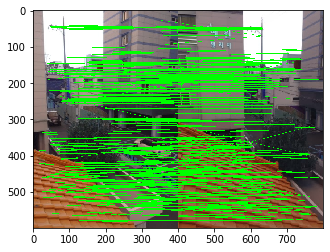

In [4]:
plt.imshow(b)

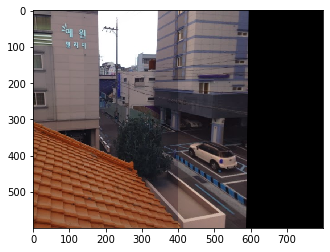

In [5]:
plt.imshow(a)